In [ ]:
from omegaconf import OmegaConf

conf = OmegaConf.load('coli.yaml')
conf.log_dir = conf.log_dir + f'd{conf.model.feature_dim}/'

# SVM + original data

In [ ]:
import numpy as np

from dataset import Dataset_coli
original_traj = Dataset_coli(conf, test=True).test_data # (N, T, L)

np.random.seed(4)
shuffle_idx = np.random.permutation(original_traj.shape[0])
X_train = original_traj[shuffle_idx][:9]
X_test = original_traj[shuffle_idx][9:]
y_train = original_traj[shuffle_idx][:9]
y_test = original_traj[shuffle_idx][9:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9, 27, 7), (9, 27, 7), (8, 27, 7), (8, 27, 7))

In [ ]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

# SVR
from sklearn.multioutput import MultiOutputRegressor

predictor = MultiOutputRegressor(SVR(kernel='rbf'))

X_train_ = X_train[:, :-1].reshape(-1, conf.coli.loci)
y_train_ = y_train[:, 1:].reshape(-1, conf.coli.loci)
predictor.fit(X_train_, y_train_)

ml_predictions = np.zeros_like(X_test)
ml_predictions[:, 0] = X_test[:, 0]
for t in range(1, conf.coli.steps):
    ml_predictions[:, t] = predictor.predict(ml_predictions[:, t-1])
print(ml_predictions.shape)

(8, 27, 7)


In [ ]:
from utilis import compute_metrics
metrics_noembed = compute_metrics(y_test[:, 1:], ml_predictions[:, 1:]) # N×(T-1)×(r2, nmse, mape)

# SVR + Neural embedding

In [ ]:
import torch
import warnings; warnings.filterwarnings("ignore")

from model import EvolutionDynamicsModel

L = conf.coli.loci
input_channels = 1
feature_dim = conf.model.feature_dim
num_heads = conf.model.num_heads
num_layers = conf.model.num_layers
codebook_size = conf.model.K
pos_encoding_type = conf.model.pos_encoding_type
use_rotation = conf.model.use_rotation
code_init = conf.model.code_init
ae = EvolutionDynamicsModel(feature_dim, L, num_heads, num_layers, pos_encoding_type=pos_encoding_type, codebook_size=codebook_size, use_rotation=use_rotation, code_init=code_init).to(conf.device)
ae.load_state_dict(torch.load(conf.log_dir + f'checkpoints/pretrain_{conf.train.max_epoch}.pth', map_location=conf.device))

<All keys matched successfully>

In [ ]:
batch_size = 1
for i in range(0, X_train.shape[0]//batch_size):
    x = torch.tensor(X_train[i*batch_size:(i+1)*batch_size]).float().to(conf.device)
    with torch.no_grad():
        z = ae.encode(x)[0] # (N, T, D)
        z = z.cpu().numpy()
        if i == 0:
            z_train = z
        else:
            z_train = np.concatenate([z_train, z], axis=0) # (N, T, D)
for i in range(0, X_test.shape[0]//batch_size):
    x_ = torch.tensor(X_test[i*batch_size:(i+1)*batch_size]).float().to(conf.device)
    with torch.no_grad():
        z_ = ae.encode(x_)[0]
        z_ = z_.cpu().numpy()
        if i == 0:
            z_test = z_
        else:
            z_test = np.concatenate([z_test, z_], axis=0)

z_train.shape, z_test.shape

((9, 27, 64), (8, 27, 64))

In [ ]:
# SVR
from sklearn.multioutput import MultiOutputRegressor

predictor = MultiOutputRegressor(SVR(kernel='rbf'))

z_train_x = z_train[:, :-1].reshape(-1, conf.model.feature_dim)
z_train_y = z_train[:, 1:].reshape(-1, conf.model.feature_dim)
predictor.fit(z_train_x, z_train_y)

ml_predictions_z = np.zeros_like(z_test)
ml_predictions_z[:, 0] = z_test[:, 0]
for t in range(1, conf.coli.steps):
    ml_predictions_z[:, t] = predictor.predict(ml_predictions_z[:, t-1])

In [ ]:
with torch.no_grad():
    for i in range(0, X_test.shape[0]//batch_size):
        z = torch.tensor(ml_predictions_z[i*batch_size:(i+1)*batch_size]).float().to(conf.device)
        x = ae.decode(z)
        x = x.cpu().numpy()
        if i == 0:
            x_pred = x
        else:
            x_pred = np.concatenate([x_pred, x], axis=0)

x_pred.shape

(8, 27, 7)

In [ ]:
from utilis import compute_metrics
metrics_embed = compute_metrics(y_test[:, 1:], x_pred[:, 1:]) # N×(T-1)×(r2, nmse, mape)

In [25]:
import pandas as pd

df = pd.DataFrame(columns=['Day', 'Embed', 'R2', 'NMSE', 'MAPE'])
for traj_idx in range(metrics_embed.shape[0]):
    for step in range(conf.coli.steps-1):
        df = df._append({'Day': step+2, 'Embed': 'Yes', 'R2': metrics_embed[traj_idx, step, 0], 'NMSE': metrics_embed[traj_idx, step, 1], 'MAPE': metrics_embed[traj_idx, step, 2]}, ignore_index=True)
        df = df._append({'Day': step+2, 'Embed': 'No', 'R2': metrics_noembed[traj_idx, step, 0], 'NMSE': metrics_noembed[traj_idx, step, 1], 'MAPE': metrics_noembed[traj_idx, step, 2]}, ignore_index=True)
df

,Day,Embed,R2,NMSE,MAPE
0,2,Yes,0.370348,0.061668,0.227395
1,2,No,-0.138631,0.111517,0.276512
2,3,Yes,0.589241,0.051959,0.227162
3,3,No,0.478006,0.066030,0.202057
4,4,Yes,-0.609971,0.423113,1.053308
...,...,...,...,...,...
411,25,No,-1.588150,0.369446,0.746881
412,26,Yes,-0.303519,0.295699,0.760251
413,26,No,-1.147157,0.487076,1.059061
414,27,Yes,0.265564,0.075766,0.258654


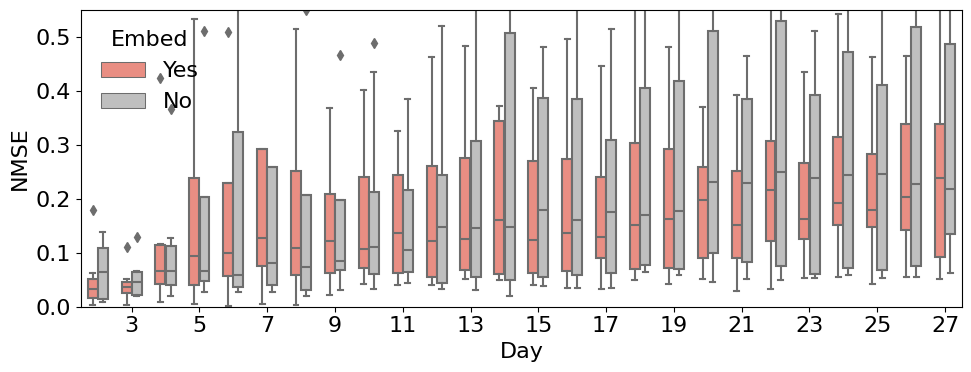

In [26]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'xtick.labelsize': 16})
plt.rcParams.update({'ytick.labelsize': 16})
plt.rcParams.update({'legend.fontsize': 16})

plt.figure(figsize=(10, 4))
sns.boxplot(x='Day', y='NMSE', hue='Embed', data=df, width=0.6, palette={"Yes": "salmon", "No": ".75"})
plt.ylim(0., .55)
plt.xlabel('Day', fontsize=16)
plt.ylabel('NMSE', fontsize=16)
plt.xticks(range(1, metrics_embed.shape[1], 2), [f'{i+2}' for i in range(1, metrics_embed.shape[1], 2)], fontsize=16)
plt.yticks([0., 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=16)
plt.legend(frameon=False, loc='upper left', fontsize=16).set_title('Embed', prop={'size': 16})
plt.tight_layout()
os.makedirs('figs/fig6', exist_ok=True)
plt.savefig('figs/fig6/evo_embed_nmse.pdf', dpi=300)

# Embedding dim

In [ ]:
import torch
from tqdm import tqdm
import warnings; warnings.filterwarnings("ignore")

from model import EvolutionDynamicsModel

df = pd.DataFrame(columns=['Day', 'Embedding Dimension', 'R2', 'NMSE', 'MAPE'])
for feature_dim in tqdm([8, 16, 24, 32, 40, 48, 56, 64]):
    conf = OmegaConf.load('coli.yaml')
    conf.log_dir = conf.log_dir + f'd{feature_dim}/'

    L = conf.coli.loci
    input_channels = 1
    num_heads = conf.model.num_heads
    num_layers = conf.model.num_layers
    codebook_size = conf.model.K
    pos_encoding_type = conf.model.pos_encoding_type
    use_rotation = conf.model.use_rotation
    code_init = conf.model.code_init
    ae = EvolutionDynamicsModel(feature_dim, L, num_heads, num_layers, pos_encoding_type=pos_encoding_type, codebook_size=codebook_size, use_rotation=use_rotation, code_init=code_init).to(conf.device)
    ae.load_state_dict(torch.load(conf.log_dir + f'checkpoints/pretrain_{conf.train.max_epoch}.pth', map_location=conf.device))

    batch_size = 1
    for i in range(0, X_train.shape[0]//batch_size):
        x = torch.tensor(X_train[i*batch_size:(i+1)*batch_size]).float().to(conf.device)
        with torch.no_grad():
            z = ae.encode(x)[0] # (N, T, D)
            z = z.cpu().numpy()
            if i == 0:
                z_train = z
            else:
                z_train = np.concatenate([z_train, z], axis=0) # (N, T, D)
    for i in range(0, X_test.shape[0]//batch_size):
        x_ = torch.tensor(X_test[i*batch_size:(i+1)*batch_size]).float().to(conf.device)
        with torch.no_grad():
            z_ = ae.encode(x_)[0]
            z_ = z_.cpu().numpy()
            if i == 0:
                z_test = z_
            else:
                z_test = np.concatenate([z_test, z_], axis=0)

    # SVR
    from sklearn.multioutput import MultiOutputRegressor

    predictor = MultiOutputRegressor(SVR(kernel='rbf'))

    z_train_x = z_train[:, :-1].reshape(-1, feature_dim)
    z_train_y = z_train[:, 1:].reshape(-1, feature_dim)
    predictor.fit(z_train_x, z_train_y)

    ml_predictions_z = np.zeros_like(z_test)
    ml_predictions_z[:, 0] = z_test[:, 0]
    for t in range(1, conf.coli.steps):
        ml_predictions_z[:, t] = predictor.predict(ml_predictions_z[:, t-1])
        
    with torch.no_grad():
        for i in range(0, X_test.shape[0]//batch_size):
            z = torch.tensor(ml_predictions_z[i*batch_size:(i+1)*batch_size]).float().to(conf.device)
            x = ae.decode(z)
            x = x.cpu().numpy()
            if i == 0:
                x_pred = x
            else:
                x_pred = np.concatenate([x_pred, x], axis=0)

    metrics_embed = compute_metrics(y_test[:, 1:], x_pred[:, 1:]) # N×(T-1)×(r2, nmse, mape)
    
    for traj_idx in range(metrics_embed.shape[0]):
        for step in range(conf.coli.steps-1):
            df = df._append({'Day': step+2, 'Embedding Dimension': feature_dim, 'R2': metrics_embed[traj_idx, step, 0], 'NMSE': metrics_embed[traj_idx, step, 1], 'MAPE': metrics_embed[traj_idx, step, 2]}, ignore_index=True)

df

100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


,Day,Embedding Dimension,R2,NMSE,MAPE
0,2.0,8.0,0.200153,0.078336,0.280389
1,3.0,8.0,0.484700,0.065183,0.258551
2,4.0,8.0,0.598959,0.105397,0.553958
3,5.0,8.0,0.509516,0.148882,0.655770
4,6.0,8.0,0.580386,0.109965,0.492882
...,...,...,...,...,...
1659,23.0,64.0,0.067940,0.126098,0.330932
1660,24.0,64.0,-0.029556,0.160878,0.363215
1661,25.0,64.0,-0.083612,0.154680,0.353744
1662,26.0,64.0,-0.280285,0.290429,0.760459


In [28]:
for traj_idx in range(metrics_embed.shape[0]):
    for step in range(conf.coli.steps-1):
        df = df._append({'Day': step+2, 'Embedding Dimension': 'Origin', 'R2': metrics_noembed[traj_idx, step, 0], 'NMSE': metrics_noembed[traj_idx, step, 1], 'MAPE': metrics_noembed[traj_idx, step, 2]}, ignore_index=True)

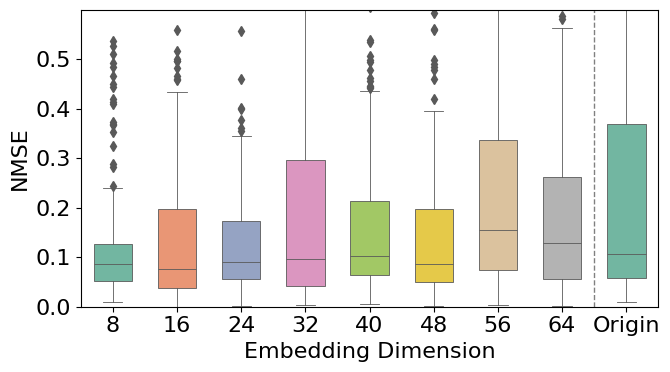

In [31]:
plt.figure(figsize=(7, 4))
sns.boxplot(df, x='Embedding Dimension', y='NMSE', palette='Set2', whis=1.5, linewidth=.6, width=.6)
plt.xlabel('Embedding Dimension')
plt.ylabel('NMSE')
plt.ylim(0., .6)
plt.yticks([0., 0.1, 0.2, 0.3, 0.4, 0.5])
plt.xticks(range(len([8, 16, 24, 32, 40, 48, 56, 64])+1), [f'{i}' for i in [8, 16, 24, 32, 40, 48, 56, 64]] + ['Origin'])
plt.axvline(x=7.5, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig('figs/fig6/evo_dim_nmse.pdf', dpi=300)